In [1]:
import math
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import seaborn as sns
from sklearn.model_selection import train_test_split
from itertools import combinations
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression,Lasso
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest,f_classif # To select important features
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor # To select important features in case of tree based model
from sklearn.metrics import mean_squared_error,r2_score
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')


In [2]:
path = '/kaggle/input/eto-calculations/Data_ETo_Calculation.xlsx'
dfs = pd.read_excel(path, sheet_name=None) 
print(dfs.keys())

dict_keys(['Bogura', 'Rangpur', 'Rajshahi', 'Dinajpur'])


In [3]:
df = pd.concat(dfs.values(), ignore_index=True)

In [4]:
df.at[59664,'SSH'] = 4.81
df.at[59999,'SSH'] = 7.91
df.at[60121,'SSH'] = 4.41

In [5]:
df['SSH'] = df['SSH'].replace(['N/A', 'missing', '-', '--'], np.nan)

In [6]:
df.describe()

,Date,Tmax,Tmin,RH,SSH,WS,Srad,Eto
count,61360,61360.000000,61360.000000,61360.000000,60995.000000,61325.000000,60992.000000,60960.000000
mean,2001-12-31 12:00:00,30.483621,20.510271,77.527066,6.298915,1.319276,16.634371,3.466561
min,1981-01-01 00:00:00,10.900000,3.200000,16.000000,0.000000,0.000000,5.563162,0.802521
25%,1991-07-02 18:00:00,27.900000,15.500000,72.000000,3.800000,0.874548,13.215674,2.438985
50%,2001-12-31 12:00:00,31.200000,22.200000,79.000000,7.200000,1.028880,16.567479,3.325586
75%,2012-07-01 06:00:00,33.400000,25.600000,84.000000,9.000000,1.543320,20.252827,4.382112
max,2022-12-31 00:00:00,43.800000,30.500000,100.000000,13.700000,26.905212,30.601783,14.220493
std,NaN,4.114329,5.813589,9.933196,3.323508,0.980193,4.880514,1.275468


In [7]:
cols = df.select_dtypes(include=['int64','float64']).columns

In [8]:
df_numeric = df[cols]

In [9]:
imputer = KNNImputer(n_neighbors=5, weights="uniform")
df_imputed = pd.DataFrame(imputer.fit_transform(df_numeric), columns=cols)

In [10]:
df[df_numeric.columns] = df_imputed

In [11]:
def outlierVisualization(dataset):
  cols = dataset.select_dtypes(include=['int64','float64']).columns
  plt.figure(figsize=(25,25))
  for i, col in enumerate(cols):
    plt.subplot(6,5,i+1)
    sns.boxplot(dataset[col])
    plt.xlabel(col)

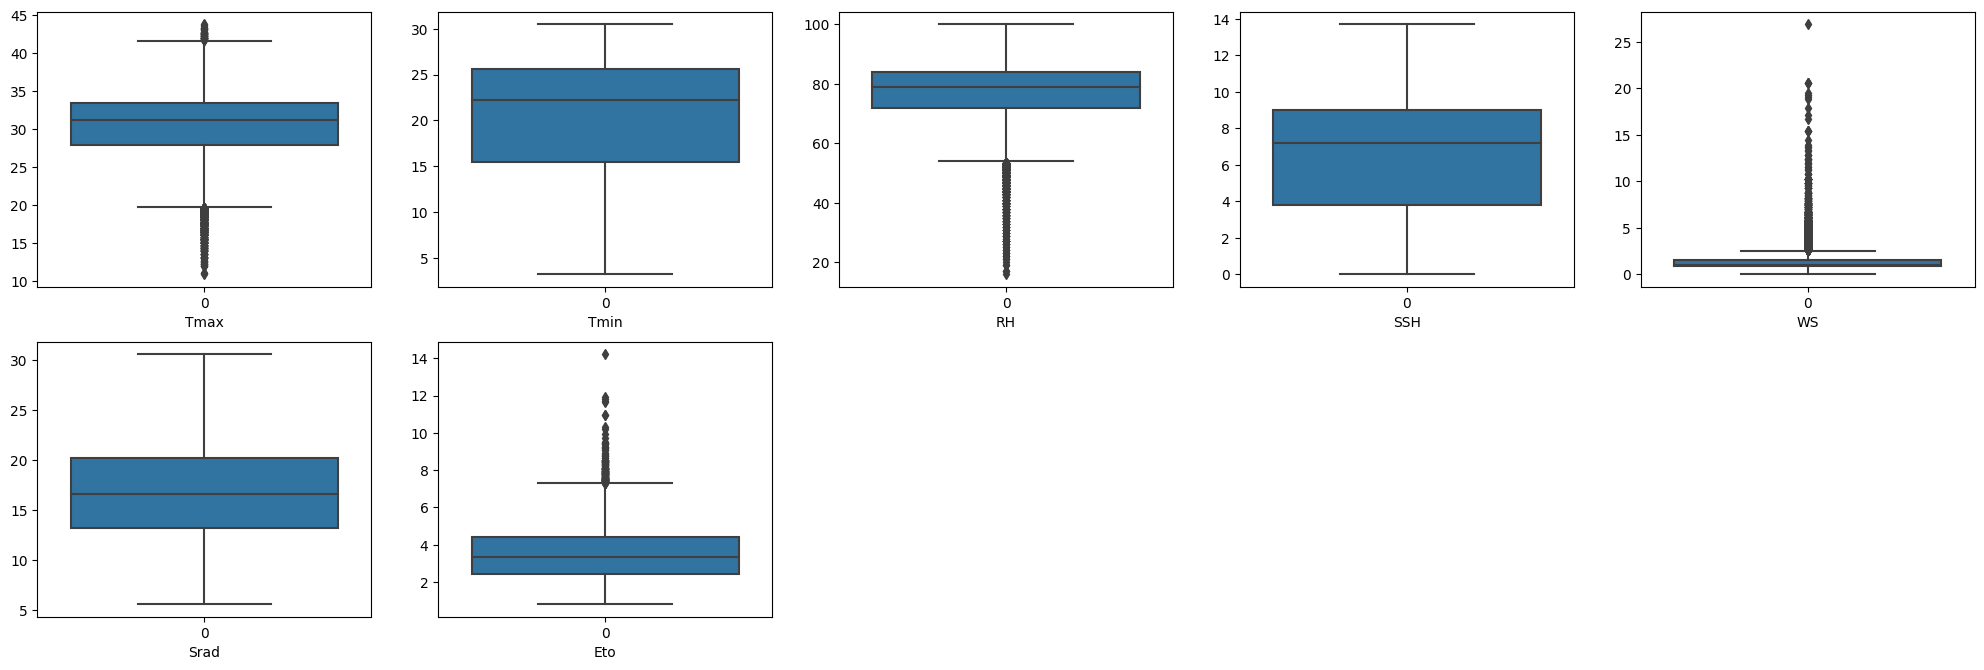

In [12]:
outlierVisualization(df)

In [13]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

In [14]:
df_cleaned = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

In [15]:
df = df_cleaned

In [16]:
date = pd.to_datetime(df.Date)
df = df.drop('Date',axis=1)
df['date'] = date
df['year'] = date.dt.year
df['month'] = date.dt.month
month_binning = {1:0,
                  2:0,
                  3:3,
                  4:3,
                  5:3,
                  6:2,
                  7:2,
                  8:2,
                  9:2,
                  10:1,
                  11:1,
                  12:0
                  }
df['season'] = df['month'].map(month_binning)

In [17]:
df_update = df.drop(['date','year','month'],axis=1)

In [18]:
cols = ['Tmax', 'Tmin', 'RH', 'WS', 'Srad','season']

In [19]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer() # also standardScaler included
transformed = pt.fit_transform(df_update[cols])
df_transformed = pd.DataFrame(transformed, columns = df_update[cols].columns)

In [20]:
cols = ['Tmax', 'Tmin', 'RH', 'WS', 'Srad','season']
X = df_transformed[cols]
y = df_update['Eto']

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,TensorDataset, DataLoader,random_split
import time
import itertools

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
X = torch.tensor(X.to_numpy().astype(dtype=np.float32)).to(device)
y = torch.tensor(y.to_numpy().astype(dtype=np.float32)).to(device)

In [24]:
dataset = TensorDataset(X, y)
BATCH_SIZE = 32
TRAIN_SIZE = int(0.8*len(dataset))
VAL_SIZE = int(0.1*TRAIN_SIZE)
TEST_SIZE = len(dataset)-TRAIN_SIZE
TRAIN_SIZE = TRAIN_SIZE-VAL_SIZE
train_data,val_data, test_data = random_split(dataset,[TRAIN_SIZE,VAL_SIZE,TEST_SIZE],generator=torch.manual_seed(42))
trainLoader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valLoader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
testLoader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [27]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Reshape, Add, LayerNormalization, LSTM, Flatten

# Model hyperparameters
input_features = 6      # e.g., Tmax, Tmin, RH, SSH, WS, Srad, season
embed_size = 32
residual_hidden = 2 * embed_size

# 1. Input Layer
inputs = Input(shape=(input_features,), name="input_layer")

# 2. Tokenization: Dense -> Reshape (like PyTorch's Linear + reshape)
x = Dense(4 * embed_size, name="token_dense")(inputs)
x = Reshape((4, embed_size), name="token_reshape")(x)

# 3. Positional Embedding (learnable)
positional_embedding = tf.Variable(tf.random.normal(shape=(1, 4, embed_size)), trainable=True, name="pos_embed")
x = Add(name="add_pos_embedding")([x, positional_embedding])

# 4. Residual Block: LSTM + Linear + Add + LayerNorm
res_lstm_out = LSTM(residual_hidden, return_sequences=True, name="residual_lstm")(x)
res_linear_out = Dense(residual_hidden, name="residual_linear")(x)
res_add = Add(name="residual_add")([res_lstm_out, res_linear_out])
res_norm = LayerNormalization(name="residual_norm")(res_add)

# 5. Second LSTM layer
lstm_out = LSTM(embed_size, return_sequences=True, name="final_lstm")(res_norm)

# 6. Flatten and Final Dense Output
flat = Flatten(name="flatten")(lstm_out)
output = Dense(1, name="output")(flat)

# 7. Build model
model = Model(inputs=inputs, outputs=output, name="ResidualLSTM")


In [48]:
model.compile(optimizer='adam', loss='mse', metrics=['mse'])
model.summary()

Model: "ResidualLSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 6)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_dense (Dense)       │ (None, 128)            │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_reshape (Reshape)   │ (None, 4, 32)          │              0 │ token_dense[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_pos_embedding (Add)   │ (1, 4, 32)             │              0 │ token_reshape[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_lstm (LSTM)      │ (1, 4, 64)             │         24,832 │ add_pos_embedding[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_linear (Dense)   │ (1, 4, 64)             │          2,112 │ add_pos_embedding[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_add (Add)        │ (1, 4, 64)             │              0 │ residual_lstm[0][0],   │
│                           │                        │                │ residual_linear[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_norm             │ (1, 4, 64)             │            128 │ residual_add[0][0]     │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ final_lstm (LSTM)         │ (1, 4, 32)             │         12,416 │ residual_norm[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (1, 128)               │              0 │ final_lstm[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (1, 1)                 │            129 │ flatten[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 40,513 (158.25 KB)

 Trainable params: 40,513 (158.25 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',      # Can also monitor 'val_mae'
    patience=8,              # Stop after 5 epochs of no improvement
    restore_best_weights=True,  # Restore model weights from best epoch
    verbose=1
)


In [60]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    callbacks = [early_stop],
    validation_split=0.1,
    verbose=1
)

Epoch 1/100
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 2/100
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 3/100
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 4/100
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 5/100
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 6/100
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 7/100
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 8/100
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 9/100
1216/1216 ━━━━━━━━━━

In [61]:
# Evaluate on test set
test_loss, test_mse = model.evaluate(X_test, y_test, verbose=1)
print("Test MSE:", test_loss)
print("Test MAE:", test_mse)
y_pred = model.predict(X_test)
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_squared_log_error,mean_absolute_percentage_error,explained_variance_score
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
msle = mean_squared_log_error(y_test, y_pred)
rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)
ev = explained_variance_score(y_test, y_pred)
print(f"r2 score:{r2}")
print(f"mse:{mse}")
print(f"mae:{mae}")
print(f"rmse:{rmse}")
print(f"msle:{msle}")
print(f"rmsle:{rmsle}")
print(f"mape:{mape}")
print(f"ev:{ev}")

338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0041 - mse: 0.0041
Test MSE: 0.00407014973461628
Test MAE: 0.00407014973461628
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
r2 score:0.9970740935244103
mse:0.004070151784295548
mae:0.042933474086924085
rmse:0.06379774121624956
msle:0.000290344582621681
rmsle:0.017039500656465287
mape:0.015134474746713165
ev:0.9970916071903126


In [62]:
model_metrics = {
    "LightGBM": {"R2": 0.992751, "MSE": 0.010105, "MAE": 0.074979, "RMSE": 0.100525, "MSLE": 0.000595, "RMSLE": 0.024383, "MAPE": 0.024377},
    "ET":       {"R2": 0.992523, "MSE": 0.010423, "MAE": 0.074004, "RMSE": 0.102091, "MSLE": 0.000602, "RMSLE": 0.024545, "MAPE": 0.023849},
    "XGBoost":  {"R2": 0.992316, "MSE": 0.010711, "MAE": 0.076737, "RMSE": 0.103495, "MSLE": 0.000629, "RMSLE": 0.025084, "MAPE": 0.024841},
    "RF":       {"R2": 0.991903, "MSE": 0.011288, "MAE": 0.076948, "RMSE": 0.106244, "MSLE": 0.000648, "RMSLE": 0.025451, "MAPE": 0.024722},
    "SVR":      {"R2": 0.989855, "MSE": 0.014142, "MAE": 0.094020, "RMSE": 0.118921, "MSLE": 0.000869, "RMSLE": 0.029485, "MAPE": 0.031142},
    "GBR":      {"R2": 0.987096, "MSE": 0.017989, "MAE": 0.100438, "RMSE": 0.134122, "MSLE": 0.001094, "RMSLE": 0.033072, "MAPE": 0.033195},
    "KNN":      {"R2": 0.983236, "MSE": 0.023370, "MAE": 0.110434, "RMSE": 0.152871, "MSLE": 0.001347, "RMSLE": 0.036704, "MAPE": 0.035812},
    "DT":       {"R2": 0.981404, "MSE": 0.025923, "MAE": 0.116483, "RMSE": 0.161005, "MSLE": 0.001467, "RMSLE": 0.038296, "MAPE": 0.037209},
    "LR":       {"R2": 0.970421, "MSE": 0.041233, "MAE": 0.157433, "RMSE": 0.203059, "MSLE": 0.004182, "RMSLE": 0.064671, "MAPE": 0.058106},
    "ADA":      {"R2": 0.956708, "MSE": 0.060349, "MAE": 0.198063, "RMSE": 0.245661, "MSLE": 0.004529, "RMSLE": 0.067297, "MAPE": 0.074173},
    "Lasso":    {"R2": 0.894804, "MSE": 0.146645, "MAE": 0.302835, "RMSE": 0.382943, "MSLE": 0.007709, "RMSLE": 0.087802, "MAPE": 0.098646}
}
model_metrics["ResLSTM"] = {
    "R2": 0.997074, "MSE": 0.004070, "MAE": 0.042933, "RMSE": 0.063798,
    "MSLE": 0.000290, "RMSLE": 0.017039, "MAPE": 0.015134
}

In [63]:
metric_df = pd.DataFrame(model_metrics).T
metric_df

,R2,MSE,MAE,RMSE,MSLE,RMSLE,MAPE
LightGBM,0.992751,0.010105,0.074979,0.100525,0.000595,0.024383,0.024377
ET,0.992523,0.010423,0.074004,0.102091,0.000602,0.024545,0.023849
XGBoost,0.992316,0.010711,0.076737,0.103495,0.000629,0.025084,0.024841
RF,0.991903,0.011288,0.076948,0.106244,0.000648,0.025451,0.024722
SVR,0.989855,0.014142,0.094020,0.118921,0.000869,0.029485,0.031142
GBR,0.987096,0.017989,0.100438,0.134122,0.001094,0.033072,0.033195
KNN,0.983236,0.023370,0.110434,0.152871,0.001347,0.036704,0.035812
DT,0.981404,0.025923,0.116483,0.161005,0.001467,0.038296,0.037209
LR,0.970421,0.041233,0.157433,0.203059,0.004182,0.064671,0.058106
ADA,0.956708,0.060349,0.198063,0.245661,0.004529,0.067297,0.074173


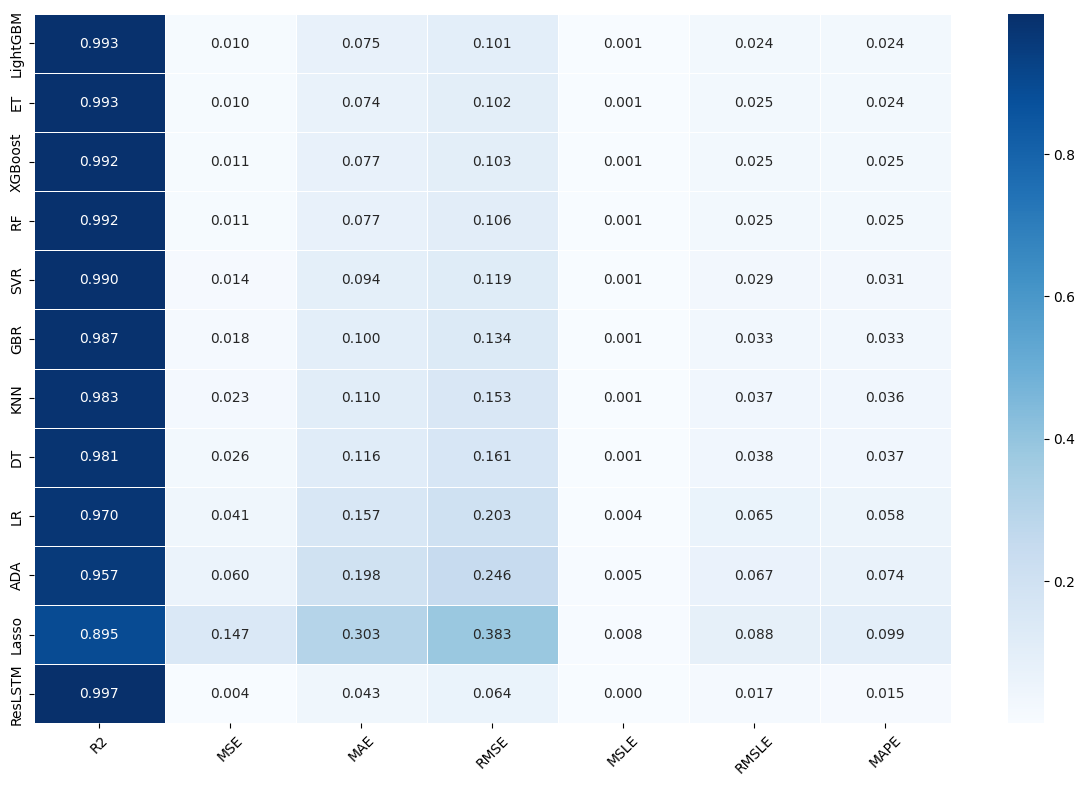

In [75]:
plt.figure(figsize=(12, 8))
sns.heatmap(metric_df, annot=True, cmap="Blues", fmt=".3f", linewidths=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('MLcomp.pdf',dpi=600)
plt.show()

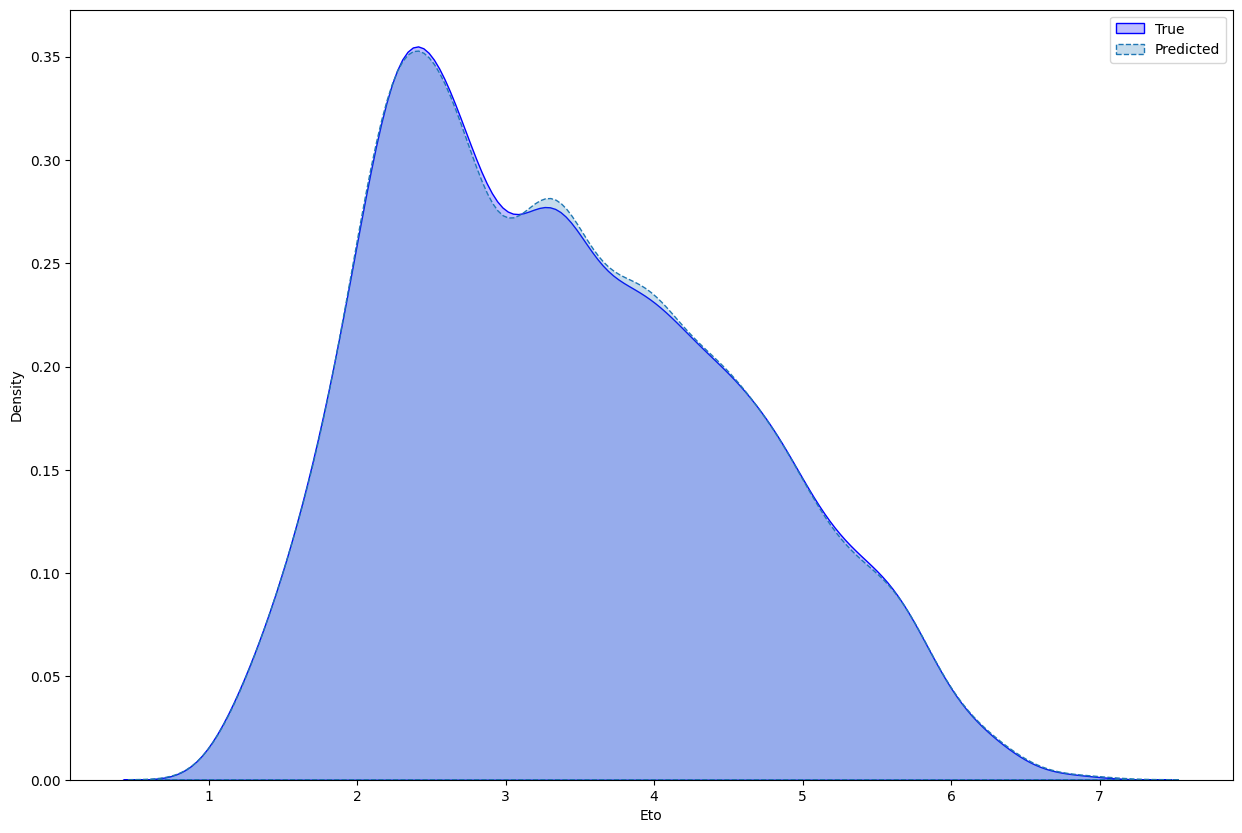

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
sns.kdeplot(y_test, label="True", shade=True, color='blue', linestyle='-')   # solid
sns.kdeplot(y_pred, label="Predicted", shade=True, color='red', linestyle='--')  # dashed
plt.legend()
plt.show()

In [28]:
class Tokenize(nn.Module):
    def __init__(self,input_features,embed_size=32):
        super(Tokenize,self).__init__()
        self.embed_size = embed_size
        self.embedding = nn.Linear(input_features,4*embed_size)
    def forward(self,x): 
        x = x.unsqueeze(1)
        x = self.embedding(x)
        x = x.reshape(x.shape[0],4,self.embed_size)
        return x
class Embeddings(nn.Module):
    def __init__(self,input_features,embed_size=32):
        super(Embeddings,self).__init__()
        self.tokenize = Tokenize(input_features,embed_size)
        self.pose = nn.Parameter(data=torch.randn(1,4,embed_size),requires_grad=True)
    def forward(self,x):
        x = self.tokenize(x)
        return self.pose + x
        
class Residual(nn.Module):
    def __init__(self,input_shape,hid_size):
        super(Residual,self).__init__()
        self.lstm = nn.LSTM(input_size=input_shape,hidden_size=hid_size,batch_first=True)
        self.linear = nn.Linear(input_shape,hid_size)
        self.norm = nn.LayerNorm(hid_size)
    def forward(self,x):
        lstm_out,_= self.lstm(x)
        linear_out = self.linear(x)
        return  self.norm(lstm_out + linear_out)
class ResidualLSTM(nn.Module):
    def __init__(self,input_shape,hid_size):
        super(ResidualLSTM,self).__init__()
        self.embedding = Embeddings(input_shape,hid_size)
        self.residual = Residual(hid_size,2*hid_size)
        self.lstm = nn.LSTM(input_size=2*hid_size,hidden_size=hid_size,batch_first=True)
        self.linear = nn.Linear(hid_size*4,1)
    def forward(self,x):
        x = self.embedding(x)
        x = self.residual(x)
        x,_ = self.lstm(x)
        x = x.reshape(x.shape[0],-1)
        x = self.linear(x)
        return x

In [29]:
import random

In [30]:
def train_model_generalized(model, trainLoader, optimizer, criterion, feature_indices, min_features=1):
    losses = []
    model.train()
    for x, label in trainLoader:
        # Random subset size
        r = random.randint(min_features, len(feature_indices))
        active_features = sorted(random.sample(feature_indices, r))
        
        # Create masked input
        newX = torch.zeros_like(x).to(device)
        newX[:, active_features] = x[:, active_features]
        
        out = model(newX)
        loss = criterion(out.squeeze(), label)
        losses.append(loss.cpu().detach().numpy())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return np.mean(losses)


def test_model(model,testLoader,criterion,indx):
    losses = []
    model.eval()
    for x_test,y_test in testLoader:
        with torch.inference_mode():
            subset = x_test[:,indx]
            newX = torch.zeros_like(x_test).to(device)
            newX[:,indx] = subset
            out = model(newX)
            loss = criterion(out.squeeze(),y_test)
            losses.append(loss.cpu().detach().numpy())
    return np.mean(losses)
def plot_graph(loss, test_loss):
    plt.figure(figsize=(10, 10))
    plt.plot(loss, c='r', label='train_loss')
    plt.plot(test_loss, c='b', label='test_loss')
    plt.xlabel('epoch')  
    plt.ylabel('loss')   
    plt.legend()

In [31]:
model = ResidualLSTM(X.shape[1],32).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00398)
EPOCHS = 100
feature_indices = list(range(6))

In [32]:
def feature_names(index):
    cols = ['Tmax', 'Tmin', 'RH', 'WS', 'Srad','season']
    selected_feature = []
    for i in index:
        selected_feature.append(cols[i])
    return selected_feature

In [33]:
best_model = None
best_loss = 10
best_iter = -1
import copy
import time

In [36]:
# Iterate over all feature combinations
train_losses = []
test_losses = []
start_time = time.time()
for epoch in range(EPOCHS):
    loss = train_model_generalized(model,trainLoader,optimizer,criterion,feature_indices)
    print(f"Epoch {epoch+1}, Loss: {loss}")
    train_losses.append(loss)
    #for r in range(1, 6):
    #    for subset in itertools.combinations(feature_indices, r):
    test_loss = test_model(model, valLoader, criterion, [0,1,2,3,4,5])
    if(test_loss<best_loss):
        best_model = copy.deepcopy(model)
        best_loss = test_loss
        best_iter = epoch
    print(f'Subset {feature_names([0,1,2,3,4,5])}, Test Loss: {test_loss}')
    test_losses.append(test_loss)
print(f'Total time: {(time.time()-start_time)/60} mins')

Epoch 1, Loss: 0.28488484025001526
Subset ['Tmax', 'Tmin', 'RH', 'WS', 'Srad', 'season'], Test Loss: 0.01855567656457424
Epoch 2, Loss: 0.2953069508075714
Subset ['Tmax', 'Tmin', 'RH', 'WS', 'Srad', 'season'], Test Loss: 0.012567204423248768
Epoch 3, Loss: 0.27579036355018616
Subset ['Tmax', 'Tmin', 'RH', 'WS', 'Srad', 'season'], Test Loss: 0.017644787207245827
Epoch 4, Loss: 0.31245413422584534
Subset ['Tmax', 'Tmin', 'RH', 'WS', 'Srad', 'season'], Test Loss: 0.024199649691581726
Epoch 5, Loss: 0.2997519373893738
Subset ['Tmax', 'Tmin', 'RH', 'WS', 'Srad', 'season'], Test Loss: 0.014441704377532005
Epoch 6, Loss: 0.29610300064086914
Subset ['Tmax', 'Tmin', 'RH', 'WS', 'Srad', 'season'], Test Loss: 0.012396750040352345
Epoch 7, Loss: 0.29701948165893555
Subset ['Tmax', 'Tmin', 'RH', 'WS', 'Srad', 'season'], Test Loss: 0.011700491420924664
Epoch 8, Loss: 0.30723029375076294
Subset ['Tmax', 'Tmin', 'RH', 'WS', 'Srad', 'season'], Test Loss: 0.015117776580154896
Epoch 9, Loss: 0.3017019927

In [ ]:
# Set font sizes
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 13,
})

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(train_losses, c='g', linestyle='--', label='train_loss')
plt.plot(test_losses, c='b', label='val_loss')
plt.scatter(best_iter,best_loss,c='r',label='best_loss')

plt.xlabel('epoch')  
plt.ylabel('loss')   
plt.text(90,0, 'lowest loss', fontsize=13, color='black')
plt.legend()
plt.savefig('loss.pdf',dpi=600)

In [ ]:
best_loss

In [ ]:
print(sum(p.numel() for p in model.parameters())/1e3, 'K parameters')

In [ ]:
torch.save(best_model.state_dict(),'/kaggle/working/MLRR0003B32E100MSE013.pth')

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [44]:
x_test = []
y_test = []
y_pred = []
for x,label in valLoader:
    #x = pt.inverse_transform(x.cpu().detach().numpy())
    #x = torch.tensor(x).to(device)
    pred = best_model(x)
    x_test.append(x.cpu().detach().numpy())
    y_test.append(label.cpu().detach().numpy())
    y_pred.append(pred.cpu().detach().numpy())
y_pred = np.concatenate(y_pred, axis=0 )
y_test = np.concatenate( y_test, axis=0 )
x_test = np.concatenate( x_test, axis=0 )

from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_squared_log_error,mean_absolute_percentage_error,explained_variance_score
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
msle = mean_squared_log_error(y_test, y_pred)
rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)
ev = explained_variance_score(y_test, y_pred)
print(f"r2 score:{r2}")
print(f"mse:{mse}")
print(f"mae:{mae}")
print(f"rmse:{rmse}")
print(f"msle:{msle}")
print(f"rmsle:{rmsle}")
print(f"mape:{mape}")
print(f"ev:{ev}")

r2 score:0.9923894076408937
mse:0.010601157322525978
mae:0.07467439770698547
rmse:0.10296192020177841
msle:0.0006757602095603943
rmsle:0.025995388627052307
mape:0.025504518300294876
ev:0.9924690127372742


In [ ]:
T = (x_test[:,0]+x_test[:,1])/2
delta = 2503*((np.exp((17.27 * T) / (T + 237.3)))/((T + 237.3)**2))
albedo = 0.23
Rn = (1 - albedo) * x_test[:,4]
G = 0
gamma = 0.0592
u2 = x_test[:,3]
Tmax = x_test[:,0]
Tmin = x_test[:,1]
RH = x_test[:,2]
es_Tmax = 0.6108 * np.exp((17.27 * Tmax) / (Tmax + 237.3))
es_Tmin = 0.6108 * np.exp((17.27 * Tmin) / (Tmin + 237.3))
es = (es_Tmax + es_Tmin) / 2
ea = RH / 100 * es
y_PM = (0.408 * delta * (Rn - G) + gamma * (900 / (T + 273)) * u2 * (es - ea)) / (delta + gamma * (1 + 0.34 * u2))

In [ ]:
print(f'MSE:{mean_squared_error(y_test,y_PM)}')
print(f'score:{r2_score(y_test,y_PM)}')

In [ ]:
sns.kdeplot(y_test, label="True", shade=True, color='blue', linestyle='-')   # solid
#sns.kdeplot(y_PM, label="Predicted", shade=True, color='red', linestyle='--')  # dashed
sns.kdeplot(y_pred, label="Res", shade=True, color='green', linestyle='-.')  # dashed
plt.legend()
plt.show()

In [ ]:
indx = np.array([4])

In [ ]:
y_pred = []
best_model.eval()
for x,label in testLoader:
    subset = x[:,indx]
    newX = torch.zeros_like(x).to(device)
    newX[:,indx] = subset
    pred = best_model(newX)
    #y_test.append(label.cpu().detach().numpy())
    y_pred.append(pred.cpu().detach().numpy())
y_pred = np.concatenate(y_pred, axis=0 )
#y_test = np.concatenate( y_test, axis=0 )

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
msle = mean_squared_log_error(y_test, y_pred)
rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)
ev = explained_variance_score(y_test, y_pred)
print(f"r2 score:{r2}")
print(f"mse:{mse}")
print(f"mae:{mae}")
print(f"rmse:{rmse}")
print(f"msle:{msle}")
print(f"rmsle:{rmsle}")
print(f"mape:{mape}")
print(f"ev:{ev}")

In [ ]:
indx = np.array([0,1,4])

In [ ]:
x_test = []
y_test = []
y_pred = []
best_model.eval()
for x,label in testLoader:
    with torch.inference_mode():
        subset = x[:,indx]
        newX = torch.zeros_like(x).to(device)
        newX[:,indx] = subset
        pred = best_model(newX)
        x_test.append(subset.cpu().detach().numpy())
        y_test.append(label.cpu().detach().numpy())
        y_pred.append(pred.cpu().detach().numpy())
y_pred = np.concatenate(y_pred, axis=0 )
y_test = np.concatenate( y_test, axis=0 )
x_test = np.concatenate( x_test, axis=0 )

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
msle = mean_squared_log_error(y_test, y_pred)
rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)
ev = explained_variance_score(y_test, y_pred)
print(f"r2 score:{r2}")
print(f"mse:{mse}")
print(f"mae:{mae}")
print(f"rmse:{rmse}")
print(f"msle:{msle}")
print(f"rmsle:{rmsle}")
print(f"mape:{mape}")
print(f"ev:{ev}")

In [ ]:
!pip install pysr

In [ ]:
from pysr import PySRRegressor

pysr_model = PySRRegressor(
    maxsize=20,
    niterations=40,  # < Increase me for better results
    binary_operators=["+", "*"],
    unary_operators=[
        "cos",
        "exp",
        "sin",
        "inv(x) = 1/x",
        # ^ Custom operator (julia syntax)
    ],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    # ^ Define operator for SymPy as well
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)
)

In [ ]:
pysr_model.fit(x_test,y_pred)

In [ ]:
# Best symbolic expression
print(pysr_model.get_best())

# Show all equations
pysr_model.equations_.iloc[11]['equation']

In [ ]:
y_symbolic = pysr_model.predict(x_test)
print("MSE:", mean_squared_error(y_pred, y_symbolic))
print("R²:", r2_score(y_pred, y_symbolic))

In [ ]:
y_pred = y_pred.reshape(-1)

In [ ]:
plt.figure(figsize=(15,10))
sns.kdeplot(y_pred, label="ResLSTM", shade=True, color='#E3651D', linestyle='--')  # dashed
sns.kdeplot(y_symbolic, label="Symbolic", shade=True, color='#750E21', linestyle='solid')  # dashed
plt.legend()
#plt.savefig('PM_comparison.pdf',dpi=600)
plt.show()

In [ ]:
plt.figure(figsize=(15,10))
sns.scatterplot(x=y_test, y=y_pred, marker='o',label='ResLSTM', alpha=0.5)
sns.scatterplot(x=y_test, y=y_symbolic, marker='^',label='symbolic', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', label='y_actual')
plt.xlabel('Actual ETo')
plt.ylabel('Predicted ETo')
plt.legend()
plt.grid(True)
#plt.savefig('residual.pdf',dpi=600)
plt.show()